# Imports

In [1]:
import sys
sys.path.append("../src")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler

# Our code
from generate_prediction import features_expert, load_dataset

# Constants

In [2]:
train_path = "../data/normalized_train.csv"

# Loading data

In [3]:
features = features_expert()
X, y = load_dataset(train_path, training=True, features=features)

## Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

X_train shape: (20, 52)
X_test  shape: (9, 52)


# GMM
## Define the model

In [6]:
gmm = GaussianMixture(n_components=3, covariance_type='full', max_iter=10_000)

## Fit data

In [7]:
gmm.fit(X_train, y_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=10000,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

## Test model

In [8]:
y_pred  = gmm.predict(X_test)
y_proba = gmm.predict_proba(X_test)

print("y test:", y_test)
print("y_pred:", y_pred)

y test: [0 1 0 1 0 1 0 0 0]
y_pred: [1 2 1 2 1 2 1 1 1]


## Confusion matrix

In [9]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[0, 6, 0],
       [0, 0, 3],
       [0, 0, 0]])

# GMM after PCA

## PCA over dataset 

In [10]:
df_data = pd.read_csv(train_path)

In [11]:
from sklearn.decomposition import PCA

In [12]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC 1','PC 2'])

In [13]:
finalDf = pd.concat([principalDf, df_data[['label']]], axis = 1)

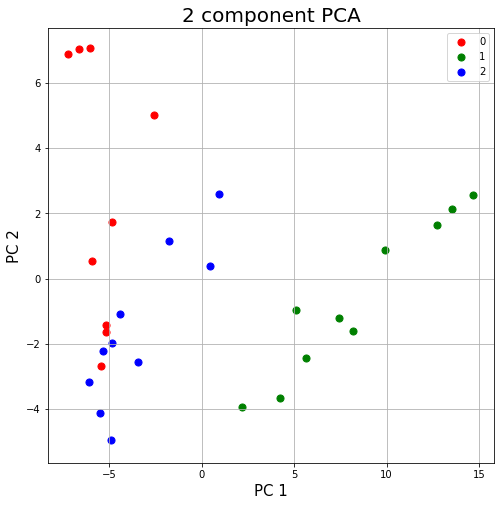

In [14]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC 1']
               , finalDf.loc[indicesToKeep, 'PC 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## GMM over 2D PCA

In [15]:
X_pca = finalDf[finalDf.columns.difference(['full_label', 'label'])].values
y_pca = finalDf["label"].values

In [16]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.3)

## Fit data from PCA

In [17]:
gmm = GaussianMixture(n_components=3, covariance_type='full', max_iter=10_000, tol=1e-8, init_params="random")

In [18]:
gmm = gmm.fit(X_pca, y_pca)

## Test model

In [19]:
y_pred_pca  = gmm.predict(X_test_pca)
y_proba_pca = gmm.predict_proba(X_pca)

#print("y test:", y_test_pca)
print("y_proba:", y_proba_pca)
print("y", y_pred_pca)
print("y", y_pca)

y_proba: [[4.20057209e-066 4.13162968e-010 1.00000000e+000]
 [3.82476347e-115 2.38352338e-006 9.99997616e-001]
 [1.42668042e-182 9.99995837e-001 4.16259053e-006]
 [0.00000000e+000 9.99998422e-001 1.57768044e-006]
 [4.94065646e-324 9.99992339e-001 7.66091935e-006]
 [5.69646437e-129 5.64345904e-003 9.94356541e-001]
 [0.00000000e+000 9.99999741e-001 2.58826495e-007]
 [2.36336143e-048 6.66634248e-014 1.00000000e+000]
 [4.22725689e-062 1.05675973e-010 1.00000000e+000]
 [9.36785724e-001 6.32142758e-002 7.44756279e-056]
 [9.91394226e-001 8.60577395e-003 3.24727066e-084]
 [9.79839814e-001 2.01601855e-002 6.59155238e-042]
 [1.00000000e+000 1.16390699e-019 3.53645643e-167]
 [1.00000000e+000 3.52105607e-024 9.95968940e-189]
 [1.00000000e+000 3.36434205e-016 2.19544996e-153]
 [9.94572329e-001 5.42767143e-003 1.25816039e-075]
 [9.99999935e-001 6.51157147e-008 4.02821337e-108]
 [9.99482841e-001 5.17158828e-004 1.45357561e-025]
 [2.88785928e-003 9.97112141e-001 2.82274399e-049]
 [1.62510638e-046 2.20

## Confusion matrix

In [20]:
cm = confusion_matrix(y_test_pca, y_pred_pca)

## Contour 

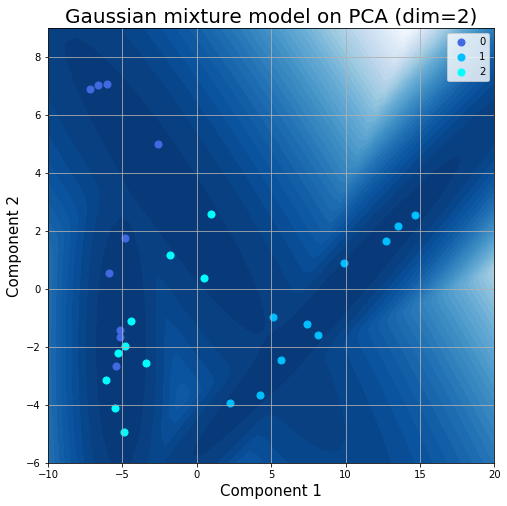

In [22]:
from matplotlib.colors import LogNorm
from matplotlib import ticker, cm
import matplotlib as mpl

targets = [0, 1, 2]
colors = ['royalblue', 'deepskyblue', 'cyan']

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

# Contour
X, Y = np.meshgrid(np.linspace(-10, 20), np.linspace(-6, 9))
XX = np.array([X.ravel(), Y.ravel()]).T
Z = gmm.score_samples(XX)


Z = Z.reshape((len(X),len(Y)))
ax.contourf(X, Y, Z, levels=40,cmap=cm.Blues)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC 1']
               , finalDf.loc[indicesToKeep, 'PC 2']
               , c = color
               , label = target
               , s = 50)

ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('Gaussian mixture model on PCA (dim=2)', fontsize = 20)
ax.legend()
ax.grid()
#legend

#cbar = plt.colorbar(ax.pcolor(Z, cmap=cm.Blues))
#cbar.ax.set_yticklabels([])
#cbar.set_label('Probabilities between 0 and 1', rotation=270)
#cbar.ax.get_yaxis().set_ticks([])
plt.show()